In [1]:
data_version = 'v5'

In [2]:
import os
import torch
import random
import numpy as np
import timm
from pylab import rcParams
from torch.optim import AdamW
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from warmup_scheduler import GradualWarmupScheduler
import albumentations as A
import torchaudio
import time
from tqdm import tqdm
import torchvision
import gc
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")


/home/dbalashova2/.local/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
def metrics_to_string(scores, key_word):
    log_info = ""
    for key in scores.keys():
        log_info = log_info + f"{key_word} {key} : {scores[key]:.4f}, "
    return log_info

In [4]:
exp_name = 'exp_'+data_version
backbone = 'eca_nfnet_l0'
seed = 42
batch_size = 64
num_workers = 0

n_epochs = 20
warmup_epo = 5
cosine_epo = n_epochs - warmup_epo

image_size = 256

lr_max = 1e-5
lr_min = 1e-7
weight_decay = 1e-6

mel_spec_params = {
    "sample_rate": 32000,
    "n_mels": 128,
    "f_min": 20,
    "f_max": 16000,
    "n_fft": 2048,
    "hop_length": 512,
    "normalized": True,
    "center" : True,
    "pad_mode" : "constant",
    "norm" : "slaney",
    "onesided" : True,
    "mel_scale" : "slaney"
}

top_db = 80
train_period = 5
val_period = 5

secondary_coef = 1.0

train_duration = train_period * mel_spec_params["sample_rate"]
val_duration = val_period * mel_spec_params["sample_rate"]

N_FOLD = 5
#fold = 2

use_amp = True
max_grad_norm = 10
early_stopping = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)
os.makedirs(os.path.join(output_folder, exp_name), exist_ok=True)



## Seed Everything

In [5]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(seed)


## Data

In [7]:

df = pd.read_csv('../data_processed/train_metadata_sets_'+data_version+'.csv').reset_index(drop=True)


df["path"] = "../data/birdclef-2024/train_audio/" + df["filename"]
df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

skf = StratifiedKFold(n_splits=N_FOLD, random_state=seed, shuffle=True)

df_test = df[df.set=='test'].reset_index(drop=True)
df = df[df.set=='train'].reset_index(drop=True)

def add_fold_column(data, val_frac=0.2, random_state=42):
    grouped = data.groupby('primary_label')
    fold = []  # To store fold assignments (0 for training, 1 for validation)

    for label, group in grouped:
        group = shuffle(group, random_state=random_state)  # Shuffle to randomize
        val_count = max(1, int(len(group) * val_frac))  # At least one instance in validation
        
        # Assign fold: 1 for validation, 0 for training
        fold.extend([1] * val_count + [0] * (len(group) - val_count))
    
    # Add the fold column back to the original DataFrame
    data['fold'] = fold
    return data

# Apply the function
df = add_fold_column(df, val_frac=0.2)

####################################################################################################


sub = pd.read_csv("../data/birdclef-2024/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}


## Dataset

In [8]:

def normalize_melspec(X, eps=1e-6):
    mean = X.mean((1, 2), keepdim=True)
    std = X.std((1, 2), keepdim=True)
    Xstd = (X - mean) / (std + eps)

    norm_min, norm_max = (
        Xstd.min(-1)[0].min(-1)[0],
        Xstd.max(-1)[0].max(-1)[0],
    )
    fix_ind = (norm_max - norm_min) > eps * torch.ones_like(
        (norm_max - norm_min)
    )
    V = torch.zeros_like(Xstd)
    if fix_ind.sum():
        V_fix = Xstd[fix_ind]
        norm_max_fix = norm_max[fix_ind, None, None]
        norm_min_fix = norm_min[fix_ind, None, None]
        V_fix = torch.max(
            torch.min(V_fix, norm_max_fix),
            norm_min_fix,
        )
        V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
        V[fix_ind] = V_fix
    return V


def read_wav(path):
    wav, org_sr = torchaudio.load(path, normalize=True)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=mel_spec_params["sample_rate"])
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav


class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, add_secondary_labels=True):
        self.df = df
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = secondary_coef
        self.add_secondary_labels = add_secondary_labels
        self.mel_transform = torchaudio.transforms.MelSpectrogram(**mel_spec_params)
        self.db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=top_db)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
        target = torch.from_numpy(target).float()
        return target

    def prepare_spec(self, path):
        wav = read_wav(path)
        wav = crop_start_wav(wav, train_duration)
        mel_spectrogram = normalize_melspec(self.db_transform(self.mel_transform(wav)))
        mel_spectrogram = mel_spectrogram * 255
        mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()
        return mel_spectrogram

    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        spec = self.prepare_spec(path)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            res = self.transform(image=spec)
            spec = res['image'].astype(np.float32)
        else:
            spec = spec.astype(np.float32)

        spec = spec.transpose(2, 0, 1)

        return {"spec": spec, "target": target, 'rating': rating}


## Model

In [9]:

class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x


class CNN(torch.nn.Module):
    def __init__(self, backbone, pretrained):
        super().__init__()

        out_indices = (3, 4)
        self.backbone = timm.create_model(
            backbone,
            features_only=True,
            pretrained=pretrained,
            in_chans=3,
            num_classes=num_classes,
            out_indices=out_indices,
        )
        feature_dims = self.backbone.feature_info.channels()
        #print(f"feature dims: {feature_dims}")

        self.global_pools = torch.nn.ModuleList([GeM() for _ in out_indices])
        self.mid_features = np.sum(feature_dims)
        self.neck = torch.nn.BatchNorm1d(self.mid_features)
        self.head = torch.nn.Linear(self.mid_features, num_classes)

    def forward(self, x):
        ms = self.backbone(x)
        h = torch.cat([global_pool(m) for m, global_pool in zip(ms, self.global_pools)], dim=1)
        x = self.neck(h)
        x = self.head(x)
        return x


## Loss

In [10]:

class FocalLossBCE(torch.nn.Module):
    def __init__(
            self,
            alpha: float = 0.25,
            gamma: float = 2,
            reduction: str = "mean",
            bce_weight: float = 1.0,
            focal_weight: float = 1.0,
    ):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight

    def forward(self, logits, targets):
        focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
            inputs=logits,
            targets=targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction,
        )
        bce_loss = self.bce(logits, targets)
        return self.bce_weight * bce_loss + self.focal_weight * focall_loss


criterion = FocalLossBCE()

## Init Utils

In [11]:
def init_logger(log_file='train.log'):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train and Val Functions

In [12]:
from sklearn.metrics import roc_auc_score

def mixup(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    data2 = data[indices]
    targets2 = targets[indices]

    lam = torch.FloatTensor([np.random.beta(alpha, alpha)])
    data = data * lam + data2 * (1 - lam)
    targets = targets * lam + targets2 * (1 - lam)

    return data, targets

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    losses = AverageMeter()
    gt = []
    preds = []
    bar = tqdm(loader, total=len(loader))
    for batch in bar:
        optimizer.zero_grad()
        spec = batch['spec']
        target = batch['target']
        spec = spec.to(device)
        target = target.to(device)

        if scaler is not None:
            with torch.cuda.amp.autocast():
                logits = model(spec)
                loss = criterion(logits, target)
            scaler.scale(loss).backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(spec)
            loss = criterion(logits, target)
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

        losses.update(loss.item(), batch["spec"].size(0))
        bar.set_postfix(
            loss=losses.avg,
            grad=grad_norm.item(),
            lr=optimizer.param_groups[0]["lr"]
        )
        gt.append(target.cpu().detach().numpy())
        preds.append(logits.sigmoid().cpu().detach().numpy())
    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    mask = gt.sum(0)>0
    gt_1 = gt[:, mask]
    preds_1 = preds[:, mask]
    roc_auc = roc_auc_score(gt_1, preds_1, average='macro', multi_class='ovr')

    return {'roc_auc':roc_auc}, losses.avg


def valid_one_epoch(model, loader):
    model.eval()
    losses = AverageMeter()
    bar = tqdm(loader, total=len(loader))
    gt = []
    preds = []

    with torch.no_grad():
        for batch in bar:
            spec = batch['spec'].to(device)
            target = batch['target'].to(device)
            logits = model(spec)
            loss = criterion(logits, target)

            losses.update(loss.item(), batch["spec"].size(0))

            gt.append(target.cpu().detach().numpy())
            preds.append(logits.sigmoid().cpu().detach().numpy())

            bar.set_postfix(loss=losses.avg)

    gt = np.concatenate(gt)
    preds = np.concatenate(preds)
    mask = gt.sum(0)>0
    mask = mask
    gt_1 = gt[:, mask]
    preds_1 = preds[:, mask]
    roc_auc = roc_auc_score(gt_1, preds_1, average='macro', multi_class='ovr')
    return {'roc_auc':roc_auc}, losses.avg



## Scheduler

In [13]:
# Fix Warmup Bug
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

## Transformation Images

In [14]:



transforms_train = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(image_size, image_size),
    A.CoarseDropout(max_height=int(image_size * 0.375), max_width=int(image_size * 0.375), max_holes=1, p=0.7),
    A.Normalize()
])

transforms_val = A.Compose([
    A.Resize(image_size, image_size),
    A.Normalize()
])

## Scheduler Plot

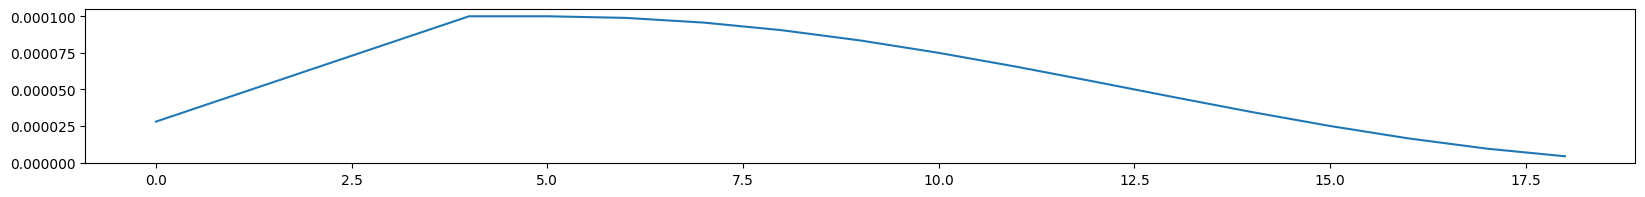

In [15]:
model = CNN(backbone=backbone, pretrained=False)
rcParams['figure.figsize'] = 20, 2

optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

lrs = []
for epoch in range(1, n_epochs):
    scheduler_warmup.step()
    lrs.append(optimizer.param_groups[0]["lr"])

plt.plot(range(len(lrs)), lrs)

In [52]:

def train_fold(model, n_epochs=5):
    fold = 1
    logger = init_logger(log_file=os.path.join(output_folder, exp_name, f"{fold}.log"))
    

    trn_df = df[df['fold'] != fold].reset_index(drop=True).sample(frac=0.5, random_state = 0)
    val_df = df[df['fold'] == fold].reset_index(drop=True).sample(frac=0.5, random_state = 0)
    test_df = df_test.sample(frac=0.5, random_state = 0)


    trn_dataset = BirdDataset(df=trn_df.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True)
    v_ds = BirdDataset(df=val_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)
    test_dataset = BirdDataset(df=test_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)

    train_loader = torch.utils.data.DataLoader(trn_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(v_ds, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)


    #model = CNN(backbone=backbone, pretrained=True).to(device)
    optimizer = AdamW(model.parameters(), lr=lr_max, weight_decay=weight_decay)
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)


    scaler = torch.cuda.amp.GradScaler() if use_amp else None
    patience = early_stopping
    best_score = 0.0
    n_patience = 0

    for epoch in range(1, n_epochs + 1):
        print(time.ctime(), 'Epoch:', epoch)

        scheduler_warmup.step(epoch-1)

        train_scores, train_losses_avg = train_one_epoch(model, train_loader, optimizer, scaler)
        train_scores_str = metrics_to_string(train_scores, "Train")
        train_info = f"Epoch {epoch} - Train loss: {train_losses_avg:.4f}, {train_scores_str}"
        print('train roc auc:', train_scores['roc_auc'])

        val_scores, val_losses_avg = valid_one_epoch(model, val_loader)
        val_scores_str = metrics_to_string(val_scores, f"Valid")
        val_info = f"Epoch {epoch} - Valid loss: {val_losses_avg:.4f}, {val_scores_str}"
        print('val roc auc:', val_scores['roc_auc'])

        test_scores, test_losses_avg = valid_one_epoch(model, test_loader)
        test_scores_str = metrics_to_string(test_scores, f"Test")
        test_info = f"Epoch {epoch} - Valid loss: {test_losses_avg:.4f}, {test_scores_str}"
        print('test roc auc:', test_scores['roc_auc'])

        val_score = val_scores["roc_auc"]

        is_better = val_score > best_score
        best_score = max(val_score, best_score)

        if is_better:
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            print(f"Epoch {epoch} - Save Best Score: {best_score:.4f} Model\n")
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"newmodel_{fold}.bin")
            )
            n_patience = 0
        else:
            n_patience += 1
            print(f"Valid loss didn't improve last {n_patience} epochs.\n")

        if n_patience >= patience:
            logger.info(
                "Early stop, Training End.\n")
            state = {
                "epoch": epoch,
                "state_dict": model.state_dict(),
                "best_loss": best_score,
                "optimizer": optimizer.state_dict(),
            }
            torch.save(
                state,
                os.path.join(output_folder, exp_name, f"final_{fold}.bin")
            )
            break

    #del model
    #torch.cuda.empty_cache()
    #gc.collect()
    return model

In [68]:
df0 = pd.read_csv('../data_processed/train_metadata_sets_'+data_version+'.csv').reset_index(drop=True)
df0["path"] = "../data/birdclef-2024/train_audio/" + df0["filename"]
df0["rating"] = np.clip(df0["rating"] / df0["rating"].max(), 0.1, 1.0)
df_unlabeled = df0[df0.set=='unlabeled']#.sample(n=64*10, random_state=0)

unlabeled_dataset = BirdDataset(df=df_unlabeled.reset_index(drop=True), transform=transforms_train, add_secondary_labels=True)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_dataset, shuffle=True, batch_size=batch_size, drop_last=True, num_workers=num_workers, pin_memory=True)

In [77]:
import torchaudio
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simplified augmentations
augmentations = transforms.Compose([
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=35),
])

# Simplified NTXentLoss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z_i, z_j):
        batch_size = z_i.size(0)
        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)

        z = torch.cat([z_i, z_j], dim=0)  # Concatenate embeddings
        similarity_matrix = torch.mm(z, z.t()) / self.temperature
        mask = torch.eye(2 * batch_size, device=z.device).bool()
        similarity_matrix.masked_fill_(mask, -9e15)
        positives = torch.cat([z_i, z_j], dim=0)
        positives = torch.exp(torch.sum(z_i * z_j, dim=-1) / self.temperature)
        denominator = torch.exp(similarity_matrix).sum(dim=1)
        loss = -torch.log(positives / denominator[:batch_size])
        return loss.mean()

class SimCLRModel(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projector = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128)
        )
    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return z


def ssl_f(model2, lr = 1e-5):

    ntxent_loss = NTXentLoss(temperature=0.5).to(device)
    optimizer2 = optim.Adam(model2.parameters(), lr=lr)
    for batch in tqdm(unlabeled_loader):
        optimizer2.zero_grad()
        spec = batch['spec'].to(device)
        spectrogram_aug1 = augmentations(spec)
        spectrogram_aug2 = augmentations(spec)
        z_i = model2(spectrogram_aug1)
        z_j = model2(spectrogram_aug2)
        loss = ntxent_loss(z_i, z_j)
        loss.backward()
        optimizer2.step()
    return model2

In [79]:
model2 = CNN(backbone=backbone, pretrained=False)
model2.to(device)

checkpoint_path = 'outputs/exp_v5/1.bin'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load model weights
model2.load_state_dict(checkpoint["state_dict"])



test_df = df_test.sample(frac=0.5, random_state = 0)


test_dataset = BirdDataset(df=test_df.reset_index(drop=True), transform=transforms_val, add_secondary_labels=True)

test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size, drop_last=False, num_workers=num_workers, pin_memory=True)


test_scores, test_losses_avg = valid_one_epoch(model2, test_loader)
test_scores_str = metrics_to_string(test_scores, f"Test")
test_info = f"Epoch {epoch} - Valid loss: {test_losses_avg:.4f}, {test_scores_str}"
print('test roc auc:', test_scores['roc_auc'])

100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=0.0401]

test roc auc: 0.7464817784525198


In [80]:
for r1 in range(5):
    for r2 in range(5):
        model2 = ssl_f(model2, lr=1e-4)
        test_scores, test_losses_avg = valid_one_epoch(model2, test_loader)
        test_scores_str = metrics_to_string(test_scores, f"Test")
        test_info = f"Epoch {epoch} - Valid loss: {test_losses_avg:.4f}, {test_scores_str}"
        print('test roc auc:', test_scores['roc_auc'])
    model2 = train_fold(model2, n_epochs=1)
    print('\n\n')

100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=4.16]


test roc auc: 0.546870940162156


100%|██████████| 8/8 [00:14<00:00,  1.81s/it, loss=1.88]


test roc auc: 0.6292411773345438


100%|██████████| 8/8 [00:14<00:00,  1.86s/it, loss=3.75]


test roc auc: 0.6531550087311442


100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=2.57]


test roc auc: 0.6689337222088301


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=4.23]


test roc auc: 0.6787913252803951
Sat Dec 14 18:41:22 2024 Epoch: 1


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=5.7e+3, loss=0.0412, lr=1e-5] 


train roc auc: 0.8851312810413682


100%|██████████| 22/22 [00:48<00:00,  2.22s/it, loss=0.0274]


val roc auc: 0.8215355518332174


100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=0.0469]


test roc auc: 0.7490677617546933
Epoch 1 - Save Best Score: 0.8215 Model






100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=3.54]


test roc auc: 0.6586714690449847


100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=3.35]


test roc auc: 0.6759544309713594


100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=3.43]


test roc auc: 0.6711127758344744


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=3.83]


test roc auc: 0.6579153977569342


100%|██████████| 8/8 [00:14<00:00,  1.84s/it, loss=3.82]


test roc auc: 0.6727524750649495
Sat Dec 14 18:50:40 2024 Epoch: 1


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=1.82e+4, loss=0.0974, lr=1e-5]


train roc auc: 0.8276517674368435


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.0417]


val roc auc: 0.7390248874172352


100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=0.0654]


test roc auc: 0.6812435091732209
Epoch 1 - Save Best Score: 0.7390 Model






100%|██████████| 8/8 [00:14<00:00,  1.85s/it, loss=3.59]


test roc auc: 0.6757533710121475


100%|██████████| 8/8 [00:15<00:00,  1.88s/it, loss=3.62]


test roc auc: 0.6671823760979102


100%|██████████| 8/8 [00:15<00:00,  1.90s/it, loss=4.16]


test roc auc: 0.661640520441205


100%|██████████| 8/8 [00:14<00:00,  1.85s/it, loss=5.1] 


test roc auc: 0.6553265431452794


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=5.53]


test roc auc: 0.6655970076081886
Sat Dec 14 19:00:00 2024 Epoch: 1


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=2.3e+4, loss=0.137, lr=1e-5] 


train roc auc: 0.7906394529073187


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0541]


val roc auc: 0.7219251486863791


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=0.0901]


test roc auc: 0.6456558805734994
Epoch 1 - Save Best Score: 0.7219 Model






100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=4.92]


test roc auc: 0.6352686965687776


100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=4.92]


test roc auc: 0.6447530943838812


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=5.07]


test roc auc: 0.6523566345437246


100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=4.83]


test roc auc: 0.6547082796275259


100%|██████████| 8/8 [00:14<00:00,  1.85s/it, loss=5.2] 


test roc auc: 0.6467486454376286
Sat Dec 14 19:09:20 2024 Epoch: 1


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=2.03e+4, loss=0.175, lr=1e-5]


train roc auc: 0.7657172444374608


100%|██████████| 22/22 [00:49<00:00,  2.25s/it, loss=0.0773]


val roc auc: 0.6875894626133197


100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=0.145]


test roc auc: 0.6152631140423871
Epoch 1 - Save Best Score: 0.6876 Model






100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=6.56]


test roc auc: 0.6151868418174108


100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=8.26]


test roc auc: 0.6226221279433766


100%|██████████| 8/8 [00:14<00:00,  1.81s/it, loss=8.44]


test roc auc: 0.6437315809908801


100%|██████████| 8/8 [00:14<00:00,  1.81s/it, loss=9.74]


test roc auc: 0.6205302081058278


100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=9.34]


test roc auc: 0.6408916540093683
Sat Dec 14 19:18:41 2024 Epoch: 1


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=3.84e+4, loss=0.223, lr=1e-5]


train roc auc: 0.7560910668102121


100%|██████████| 22/22 [00:49<00:00,  2.26s/it, loss=0.129]


val roc auc: 0.6617343191189171


100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=0.174]


test roc auc: 0.636278418862398
Epoch 1 - Save Best Score: 0.6617 Model






In [81]:
model2 = train_fold(model2, n_epochs=10)

Sat Dec 14 19:23:23 2024 Epoch: 1


100%|██████████| 86/86 [03:35<00:00,  2.50s/it, grad=1.99e+4, loss=0.0709, lr=1e-5]


train roc auc: 0.6909720806260234


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0638]


val roc auc: 0.6565369551091358


100%|██████████| 8/8 [00:14<00:00,  1.84s/it, loss=0.116] 


test roc auc: 0.6068325345150636
Epoch 1 - Save Best Score: 0.6565 Model

Sat Dec 14 19:28:03 2024 Epoch: 2


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=1.09e+4, loss=0.037, lr=2.8e-5] 


train roc auc: 0.708675065268028


100%|██████████| 22/22 [00:49<00:00,  2.25s/it, loss=0.114] 


val roc auc: 0.6894485916650801


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=0.132] 


test roc auc: 0.612031885558311
Epoch 2 - Save Best Score: 0.6894 Model

Sat Dec 14 19:32:46 2024 Epoch: 3


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=4.54e+4, loss=0.0303, lr=4.6e-5]


train roc auc: 0.7766150144763108


100%|██████████| 22/22 [00:49<00:00,  2.27s/it, loss=1.15] 


val roc auc: 0.6984198635354788


100%|██████████| 8/8 [00:14<00:00,  1.84s/it, loss=0.556]


test roc auc: 0.6186754285542909
Epoch 3 - Save Best Score: 0.6984 Model

Sat Dec 14 19:37:29 2024 Epoch: 4


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=1.01e+4, loss=0.0273, lr=6.4e-5]


train roc auc: 0.8241513928024978


100%|██████████| 22/22 [00:48<00:00,  2.22s/it, loss=0.047] 


val roc auc: 0.7943001746376439


100%|██████████| 8/8 [00:14<00:00,  1.82s/it, loss=0.0966]


test roc auc: 0.6580111772004765
Epoch 4 - Save Best Score: 0.7943 Model

Sat Dec 14 19:42:11 2024 Epoch: 5


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=5.14e+3, loss=0.022, lr=8.2e-5] 


train roc auc: 0.8910762752121599


100%|██████████| 22/22 [00:48<00:00,  2.21s/it, loss=0.0376]


val roc auc: 0.8464138405253904


100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=0.0938]


test roc auc: 0.6916026015683493
Epoch 5 - Save Best Score: 0.8464 Model

Sat Dec 14 19:46:51 2024 Epoch: 6


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=3.11e+3, loss=0.0184, lr=0.0001]


train roc auc: 0.933679323479277


100%|██████████| 22/22 [00:49<00:00,  2.25s/it, loss=0.0337]


val roc auc: 0.8627005123840952


100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=0.0644]


test roc auc: 0.731767353536441
Epoch 6 - Save Best Score: 0.8627 Model

Sat Dec 14 19:51:34 2024 Epoch: 7


100%|██████████| 86/86 [03:34<00:00,  2.50s/it, grad=2.46e+3, loss=0.0151, lr=0.0001]


train roc auc: 0.9665158379933128


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0216]


val roc auc: 0.8895248594737224


100%|██████████| 8/8 [00:14<00:00,  1.86s/it, loss=0.0465]


test roc auc: 0.7533987463482177
Epoch 7 - Save Best Score: 0.8895 Model

Sat Dec 14 19:56:14 2024 Epoch: 8


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=2.38e+3, loss=0.0125, lr=9.57e-5]


train roc auc: 0.9857125258773672


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.0195]


val roc auc: 0.9084167056886457


100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=0.0443]


test roc auc: 0.7662402642093761
Epoch 8 - Save Best Score: 0.9084 Model

Sat Dec 14 20:00:57 2024 Epoch: 9


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=1.84e+3, loss=0.0104, lr=9.05e-5] 


train roc auc: 0.9926726482304108


100%|██████████| 22/22 [00:48<00:00,  2.21s/it, loss=0.0202]


val roc auc: 0.9071073142468968


100%|██████████| 8/8 [00:14<00:00,  1.78s/it, loss=0.0441]


test roc auc: 0.7843059741341357
Valid loss didn't improve last 1 epochs.

Sat Dec 14 20:05:37 2024 Epoch: 10


100%|██████████| 86/86 [03:38<00:00,  2.54s/it, grad=2e+3, loss=0.00881, lr=8.35e-5]   


train roc auc: 0.9948904314973642


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0176]


val roc auc: 0.9181125916165017


100%|██████████| 8/8 [00:14<00:00,  1.87s/it, loss=0.0433]


test roc auc: 0.7909033161231008
Epoch 10 - Save Best Score: 0.9181 Model



In [82]:
model2 = train_fold(model2, n_epochs=10)

Sat Dec 14 20:15:33 2024 Epoch: 1


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=2.55e+3, loss=0.00699, lr=1e-5]


train roc auc: 0.9980454808612129


100%|██████████| 22/22 [00:49<00:00,  2.26s/it, loss=0.0192]


val roc auc: 0.9250753784021302


100%|██████████| 8/8 [00:15<00:00,  1.89s/it, loss=0.0441]


test roc auc: 0.7979941935248913
Epoch 1 - Save Best Score: 0.9251 Model

Sat Dec 14 20:20:17 2024 Epoch: 2


100%|██████████| 86/86 [03:38<00:00,  2.54s/it, grad=3.18e+3, loss=0.00663, lr=2.8e-5]


train roc auc: 0.9979721335034614


100%|██████████| 22/22 [00:49<00:00,  2.26s/it, loss=0.0185]


val roc auc: 0.9219896576515656


100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=0.0486]


test roc auc: 0.7979490528616845
Valid loss didn't improve last 1 epochs.

Sat Dec 14 20:25:01 2024 Epoch: 3


100%|██████████| 86/86 [03:36<00:00,  2.51s/it, grad=3.59e+3, loss=0.00631, lr=4.6e-5]


train roc auc: 0.9980941700642321


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0177]


val roc auc: 0.9263773281958464


100%|██████████| 8/8 [00:14<00:00,  1.83s/it, loss=0.0422]


test roc auc: 0.7947016098459114
Epoch 3 - Save Best Score: 0.9264 Model

Sat Dec 14 20:29:43 2024 Epoch: 4


100%|██████████| 86/86 [03:37<00:00,  2.52s/it, grad=3.68e+3, loss=0.00583, lr=6.4e-5]


train roc auc: 0.9984908617949542


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.0202]


val roc auc: 0.9248599209687557


100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=0.048] 


test roc auc: 0.7902814497923573
Valid loss didn't improve last 1 epochs.

Sat Dec 14 20:34:24 2024 Epoch: 5


100%|██████████| 86/86 [03:39<00:00,  2.55s/it, grad=2.45e+3, loss=0.00555, lr=8.2e-5]


train roc auc: 0.9987543130067357


100%|██████████| 22/22 [00:48<00:00,  2.22s/it, loss=0.0197]


val roc auc: 0.9285960686171405


100%|██████████| 8/8 [00:14<00:00,  1.86s/it, loss=0.0478]


test roc auc: 0.7891796903530356
Epoch 5 - Save Best Score: 0.9286 Model

Sat Dec 14 20:39:09 2024 Epoch: 6


100%|██████████| 86/86 [03:35<00:00,  2.51s/it, grad=3.99e+3, loss=0.00503, lr=0.0001]


train roc auc: 0.9989274279407471


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.0276]


val roc auc: 0.9118330488995696


100%|██████████| 8/8 [00:14<00:00,  1.81s/it, loss=0.0503]


test roc auc: 0.780480887941295
Valid loss didn't improve last 1 epochs.

Sat Dec 14 20:43:49 2024 Epoch: 7


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=2.32e+3, loss=0.00433, lr=0.0001]


train roc auc: 0.9992846101098831


100%|██████████| 22/22 [00:48<00:00,  2.22s/it, loss=0.021] 


val roc auc: 0.9210034060557656


100%|██████████| 8/8 [00:14<00:00,  1.84s/it, loss=0.0506]


test roc auc: 0.786109253893283
Valid loss didn't improve last 2 epochs.

Sat Dec 14 20:48:30 2024 Epoch: 8


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=2.82e+3, loss=0.00391, lr=9.57e-5]


train roc auc: 0.9993841648552672


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.0211]


val roc auc: 0.9237481422041


100%|██████████| 8/8 [00:14<00:00,  1.85s/it, loss=0.05]  


test roc auc: 0.7913375606059558
Valid loss didn't improve last 3 epochs.

Sat Dec 14 20:53:11 2024 Epoch: 9


100%|██████████| 86/86 [03:36<00:00,  2.52s/it, grad=3.14e+3, loss=0.00358, lr=9.05e-5]


train roc auc: 0.9994052426973915


100%|██████████| 22/22 [00:49<00:00,  2.24s/it, loss=0.018] 


val roc auc: 0.9231448210960901


100%|██████████| 8/8 [00:14<00:00,  1.80s/it, loss=0.0451]


test roc auc: 0.7848159601138902
Valid loss didn't improve last 4 epochs.

Sat Dec 14 20:57:52 2024 Epoch: 10


100%|██████████| 86/86 [03:37<00:00,  2.53s/it, grad=1.9e+3, loss=0.00291, lr=8.35e-5] 


train roc auc: 0.9997043075460275


100%|██████████| 22/22 [00:49<00:00,  2.23s/it, loss=0.0184]


val roc auc: 0.9185446418857481


100%|██████████| 8/8 [00:14<00:00,  1.79s/it, loss=0.0469]

test roc auc: 0.7990354962489211
Valid loss didn't improve last 5 epochs.

